# Improving Demand Forecasting
## Capstone Project 2: Exploratory & Statistical Data Analysis

This data science study focuses on the analysis of a time series that describes the sales of items at multiple stores. In this exploration, the dataset is imported from a csv file into a pandas dataframe. The general properties of the dataset are revealed with descriptive statistics and time series plots of the total sales numbers. 

Statistical and visual data analysis are performed to check for the trend, seasonality, variance, autocorrelation, and stationarity of the time series. By the end of this exploration, the dataset is ready for time series modeling.

In [0]:
%matplotlib inline
from __future__ import print_function

import warnings
import itertools
import numpy as np
warnings.filterwarnings("ignore")

import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
plt.style.use('fivethirtyeight')

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Importing data
Dataset: Store Item Demand Forecasting Challenge from Kaggle

https://www.kaggle.com/c/demand-forecasting-kernels-only/data

Unit: Single

The dataset provided comes in 2 csv files, train.csv and test.csv. The training dataset with sales numbers is imported for exploratory data analysis.

In [2]:
df = pd.read_csv('train.csv', parse_dates=["date"])
df.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [3]:
df.describe()

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


The training dataset contains 913000 sales records of 50 items across 10 stores. The sales numbers per day for the 50 items range from 0 to 231 with a mean of 52. The sales records are from 2013 to the end of 2017.

In [4]:
print('Time period start: {}\nTime period end: {}'.format(df.date.min(),df.date.max()))

Time period start: 2013-01-01 00:00:00
Time period end: 2017-12-31 00:00:00


In [5]:
df.columns

Index(['date', 'store', 'item', 'sales'], dtype='object')

In [6]:
df.shape

(913000, 4)

In [0]:
dates = df.date
df['month'] = dates.dt.to_period('m')

In [0]:
df_month = pd.DataFrame({'sales': df.groupby('month')['sales'].sum()})

#### Total Sales
Reviewing the monthly total sales numbers over time for all items in all stores reveals a time series with seasonality and an upwards trend. 

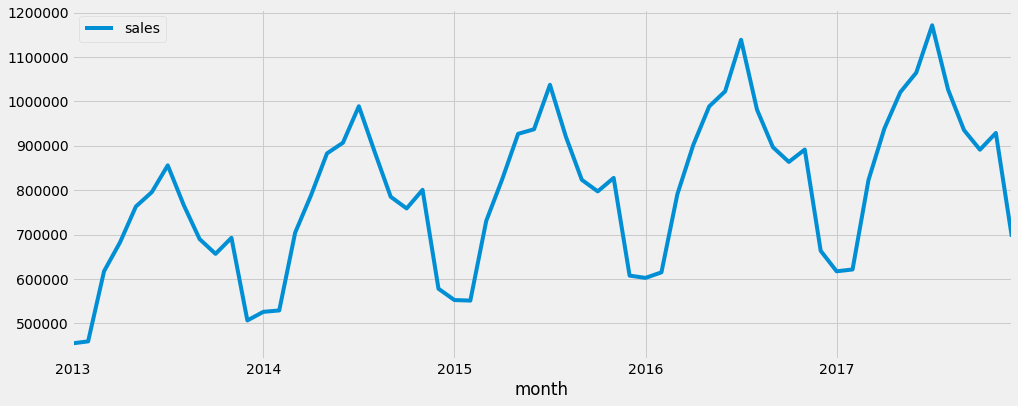

In [9]:
df_month.plot(figsize=(15,6))
plt.show()

#### Reviewing plots of the density of observations can provide further insight into the structure of the data:

- The distribution is not perfectly Gaussian (normal distribution).
- The distribution is left shifted.
- Transformations might be useful prior to modelling.

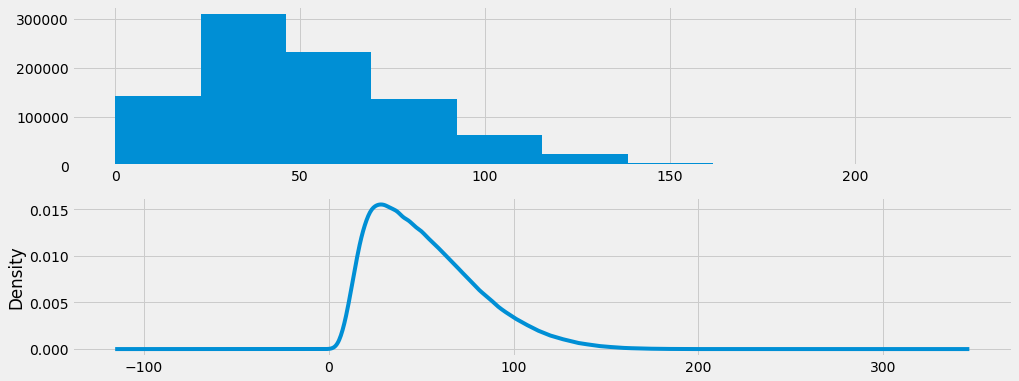

In [10]:
plt.figure(1)
plt.subplot(211)
df.sales.hist()
plt.subplot(212)
df.sales.plot(kind='kde',figsize=(15, 6))
plt.show()

#### Box and Whisker Plots:

- Median values across years confirms an upwards trend
- Slight increase in the spread, or middle 50% of the data (boxes) over time
- A model considering seasonality might work well

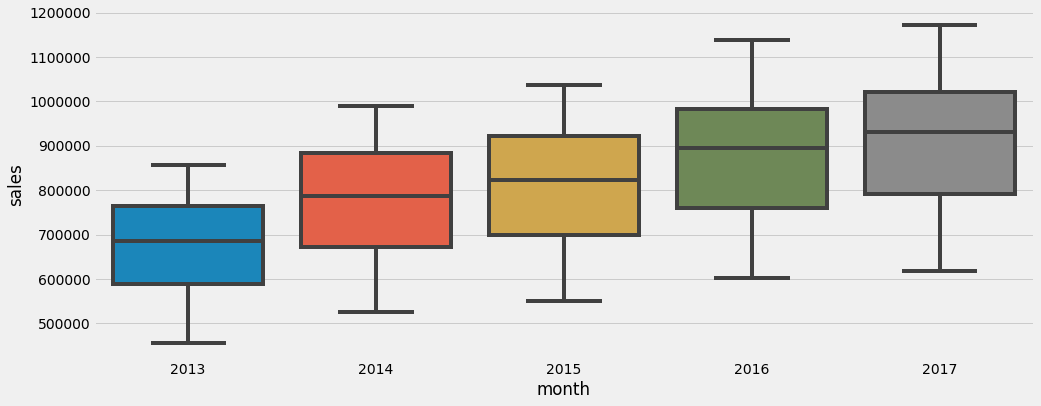

In [11]:
fig, ax = plt.subplots(figsize=(15,6))
sns.boxplot(df_month.index.year, df_month.sales, ax=ax);

#### Decomposing using statsmodels:

We can use statsmodels to perform a decomposition of this time series. The decomposition of time series is a statistical task that deconstructs a time series into several components, each representing one of the underlying categories of patterns. With statsmodels we will be able to see the trend, seasonal, and residual components of our data.

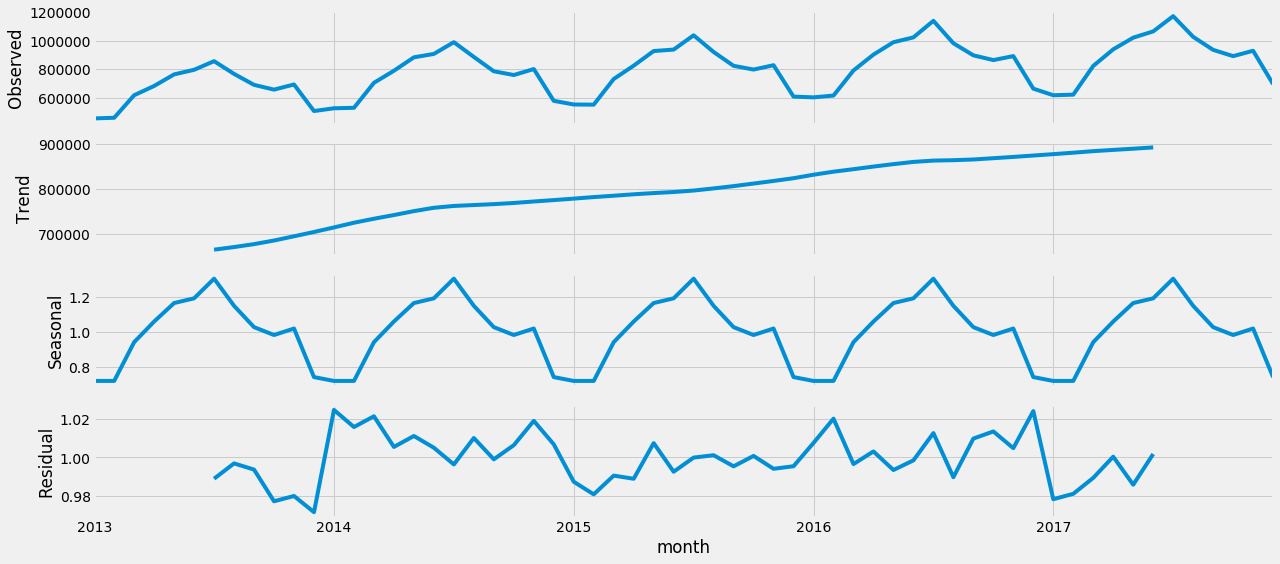

In [12]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(df_month, model='multiplicative', freq=12)
fig = decomposition.plot()
plt.show()

#### Sales per Item per Store
Exploring the sales of each item per store (item 1 store 1 used below), which is the series that we will ultimately be forecasting, reveals less uniform seasonality from year to year with an overall upwards trend. 

In [0]:
df_item_store = pd.DataFrame({'sales': df[(df['item']==1) & (df['store']==1)].groupby(['month'])['sales'].sum()})

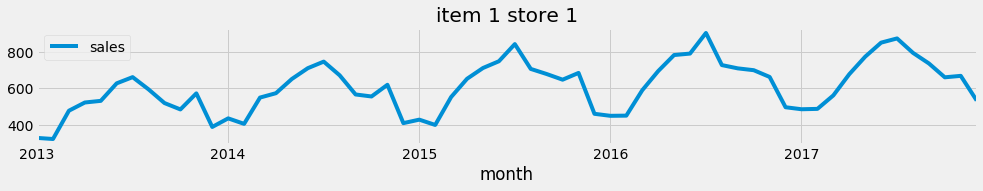

In [14]:
df_item_store.plot(figsize=(15,2),title='item 1 store 1')
plt.show;

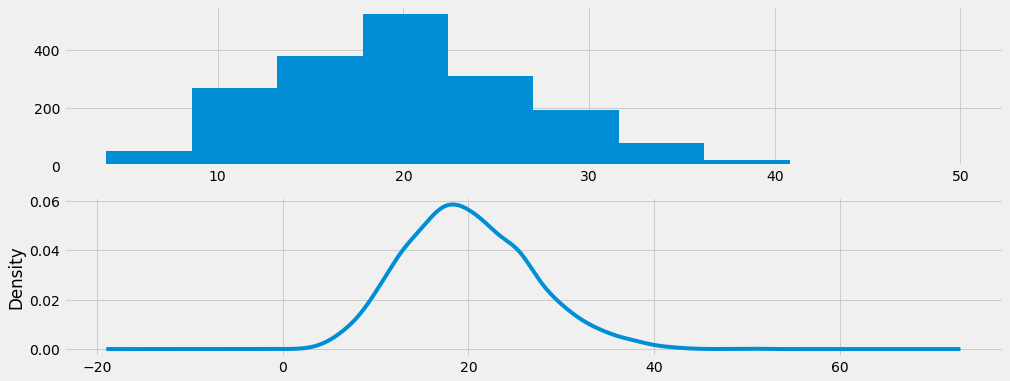

In [15]:
plt.figure(1)
plt.subplot(211)
df[(df['item']==1) & (df['store']==1)].sales.hist()
plt.subplot(212)
df[(df['item']==1) & (df['store']==1)].sales.plot(kind='kde',figsize=(15, 6))
plt.show();

Box and whisker plot shows increase in the spread, or middle 50% of the data (boxes) over time.

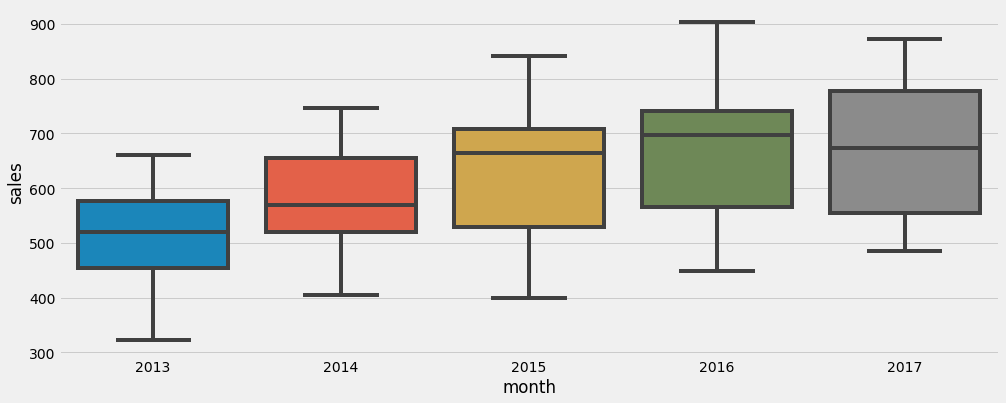

In [16]:
fig, ax = plt.subplots(figsize=(15,6))
sns.boxplot(df_item_store.index.year, df_item_store.sales, ax=ax);

Decomposition of the series shows strong upward trend and seasonality. The series will need transformation for stationarity prior to modeling.

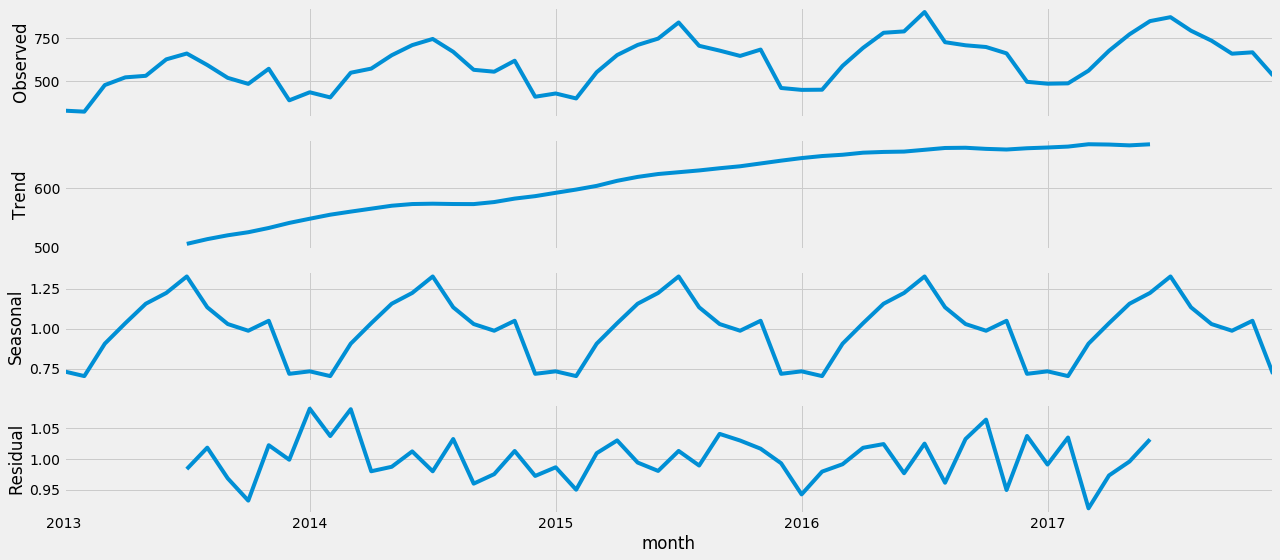

In [17]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(df_item_store, model='multiplicative', freq=12)
fig = decomposition.plot()
plt.show();

### Stationarity
In order to model a time series, it must be stationary. Most time series models work with stationary time series because non-stationarity increases unpredictability. Stationary means that the distribution of the data doesn't change with time. For a time series to be stationary, it must fulfill 3 criteria:

- Zero trend: the series does not grow nor shrink over time
- Constant variance: average distance of the data points from the zero line does not change
- Constant autocorrelation: how each value in the series is related to its neighbors stays the same

Identifying whether a time series is stationary or non-stationary is very important. If it is stationary, then we can use ARMA models to predict the next values of the time series. If it is non-stationary, then ARMA models cannot be used. However, in most scenarios non-stationary time series can be transformed to stationary ones.

Stationarity can be checked using the augmented Dickey-Fuller Test. Here the null hypothesis is that the time series is non-stationary. The test results comprise of a Test Statistic and some Critical Values at different confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, then the null hypothesis is rejected and the time series is stationary.

#### Augmented Dickey-Fuller Test

The test is performed on item 1 at store 1. Here the test statistic -3.16 is less than the 5% critical value but greater than the 1% critical value, and the p-value 0.02 is greater than 0.05. Since the series has a strong upward trend, we will use the strictest 1% critical value to test the hypothesis. Therefore, we accept the null hypothesis and the time series is non-stationary. Transformations are necessary prior to modeling.

In [18]:
#Perform Dickey-Fuller test:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(df[(df['item']==1) & (df['store']==1)].sales, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                   -3.157671
p-value                           0.022569
#Lags Used                       23.000000
Number of Observations Used    1802.000000
Critical Value (1%)              -3.433984
Critical Value (5%)              -2.863145
Critical Value (10%)             -2.567625
dtype: float64


## Transformations for Stationarity
Differecing is the technique used below to transform the time series for stationarity. In this technique, we take the difference of the observation at a particular instant with that at the previous instant. First order differencing in Pandas is used.

In [0]:
df_1_1 = df[(df['item']==1) & (df['store']==1)]
diff_1_1 = df_1_1.sales - df_1_1.sales.shift(1)
diff_1_1 = diff_1_1.dropna(inplace = False)

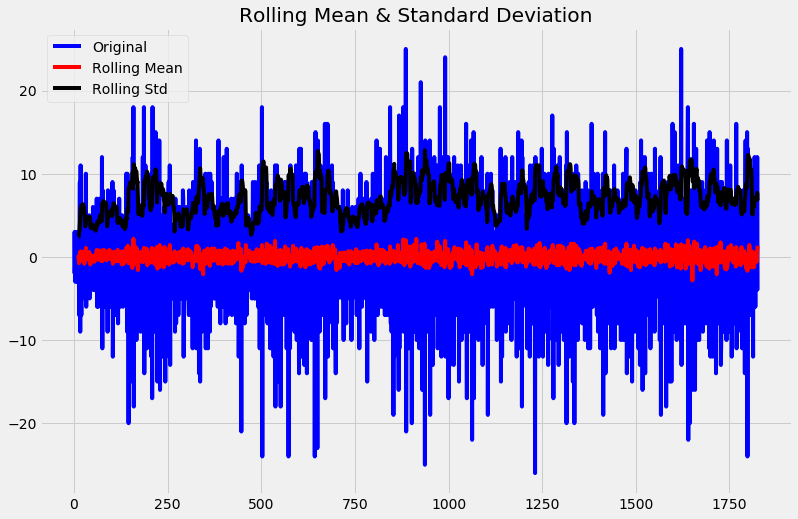

In [20]:
#Get rolling statistics
rolmean = diff_1_1.rolling(12).mean()
rolstd = diff_1_1.rolling(12).std()

#Plot rolling statistics:
fig = plt.figure(figsize=(12, 8))
orig = plt.plot(diff_1_1, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show();

After differencing, the test statistic is less than the 1% critical value and the p-value is much smaller than 0.05. The series also shows constant variance over time upon plotting its rolling statistics. We can now reject the null hypothesis and state that the transformed time series is stationary.

In [21]:
#Perform Dickey-Fuller test:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(diff_1_1, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                -1.267679e+01
p-value                        1.210928e-23
#Lags Used                     2.200000e+01
Number of Observations Used    1.802000e+03
Critical Value (1%)           -3.433984e+00
Critical Value (5%)           -2.863145e+00
Critical Value (10%)          -2.567625e+00
dtype: float64


## Modeling Preparation
Once we know the transformation needed based on the explorations of item 1 at store 1, a custom function is written to prepare the time series of each item per store for modeling. 

In [0]:
# Function that takes a time series dataframe and transforms it with first order differencing, 
# returning the transformed time series as a pandas series
def ts_diff(ts):
    diff = ts.sales - ts.sales.shift(1)
    return diff.dropna()

In [0]:
# Create arrays of item numbers and store numbers for iterating through
items = np.arange(1,51)
stores = np.arange(1,11)

# Call transformation function for the time series of each item in each store and append the result to an array
ts = [ts_diff(df[(df['item']==i) & (df['store']==s)]) for i in items for s in stores]

## Summary

The item sales dataset includes the sales data for 50 items across 10 stores over 5 years in time. Exploratory data analysis by plotting the time series of total sales, as well as the sales of each item per store reveals strong upwards trend and seasonality. The augmented Dickey-Fuller test for stationarity in trend provides a test statistic that is greater than the 1% critical value and a p-value greater than 0.05, which accepts the null hypothesis of the time series having a trend that is non-stationary.

Using first order differencing, the time series is transformed for trend stationarity. However, there is still seasonality to consider when modeling the time series. SARIMA model can be used for the time series when dealing with seasonality.

In [0]:
with open('/content/drive/My Drive/Capstone Project 2/data/processed/ts.txt', 'w') as f:
    for item in ts:
        f.write("%s\n" % item)

df.to_csv('/content/drive/My Drive/Capstone Project 2/data/processed/df.csv',index='False')